Сжимающий автоэнкодер

In [1]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test  = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))



In [2]:
from keras.layers import Input, Dense, Flatten, Reshape
from keras.models import Model

def create_dense_ae():
    # Размерность кодированного представления
    encoding_dim = 49

    # Энкодер
    # Входной плейсхолдер
    input_img = Input(shape=(28, 28, 1)) # 28, 28, 1 - размерности строк, столбцов, фильтров одной картинки, без батч-размерности
    # Вспомогательный слой решейпинга
    flat_img = Flatten()(input_img)
    # Кодированное полносвязным слоем представление
    encoded = Dense(encoding_dim, activation='relu')(flat_img)
    
    # Декодер
    # Раскодированное другим полносвязным слоем изображение
    input_encoded = Input(shape=(encoding_dim,))
    flat_decoded = Dense(28*28, activation='sigmoid')(input_encoded)
    decoded = Reshape((28, 28, 1))(flat_decoded)

    # Модели, в конструктор первым аргументом передаются входные слои, а вторым выходные слои
    # Другие модели можно так же использовать как и слои
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

In [3]:
encoder, decoder, autoencoder = create_dense_ae()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [4]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 49)                38465     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         39200     
                                                                 
Total params: 77,665
Trainable params: 77,665
Non-trainable params: 0
_________________________________________________________________


In [5]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
235/235 [==============================] - 1s 3ms/step - loss: 0.2557 - val_loss: 0.1715
Epoch 2/10
235/235 [==============================] - 1s 3ms/step - loss: 0.1536 - val_loss: 0.1370
Epoch 3/10
235/235 [==============================] - 1s 3ms/step - loss: 0.1285 - val_loss: 0.1184
Epoch 4/10
235/235 [==============================] - 1s 3ms/step - loss: 0.1136 - val_loss: 0.1065
Epoch 5/10
235/235 [==============================] - 1s 3ms/step - loss: 0.1036 - val_loss: 0.0982
Epoch 6/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0964 - val_loss: 0.0924
Epoch 7/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0912 - val_loss: 0.0881
Epoch 8/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0875 - val_loss: 0.0852
Epoch 9/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0850 - val_loss: 0.0829
Epoch 10/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0833 - val_loss: 0.0816

In [6]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()


In [7]:
n = 10

imgs = x_test[:n]
encoded_imgs = encoder.predict(imgs, batch_size=n)
encoded_imgs[0]

1/1 [==============================] - 0s 34ms/step


array([ 5.6745143 ,  3.764265  ,  5.2156596 ,  3.0808687 ,  6.8913345 ,
        8.695607  ,  3.2105393 ,  4.3044567 ,  7.149445  ,  9.176738  ,
        3.311955  ,  4.828355  ,  6.290786  ,  1.8462067 ,  5.6678033 ,
        6.841432  ,  2.8849268 ,  4.950867  ,  5.218666  ,  7.742263  ,
        2.6871624 ,  6.298246  ,  1.7942698 ,  8.670469  ,  5.6400847 ,
        4.530891  ,  2.885548  ,  2.5998063 ,  1.7502749 , 10.826348  ,
        0.53882456,  6.5860972 ,  9.110903  ,  8.081694  ,  1.3706914 ,
       12.531626  ,  5.4108706 ,  9.030842  ,  6.789983  ,  3.358981  ,
        4.3683314 ,  1.7130165 ,  0.94189304,  1.6969986 ,  7.323637  ,
        2.5578403 ,  5.9200616 ,  5.4031982 ,  2.237746  ], dtype=float32)

1/1 [==============================] - 0s 27ms/step


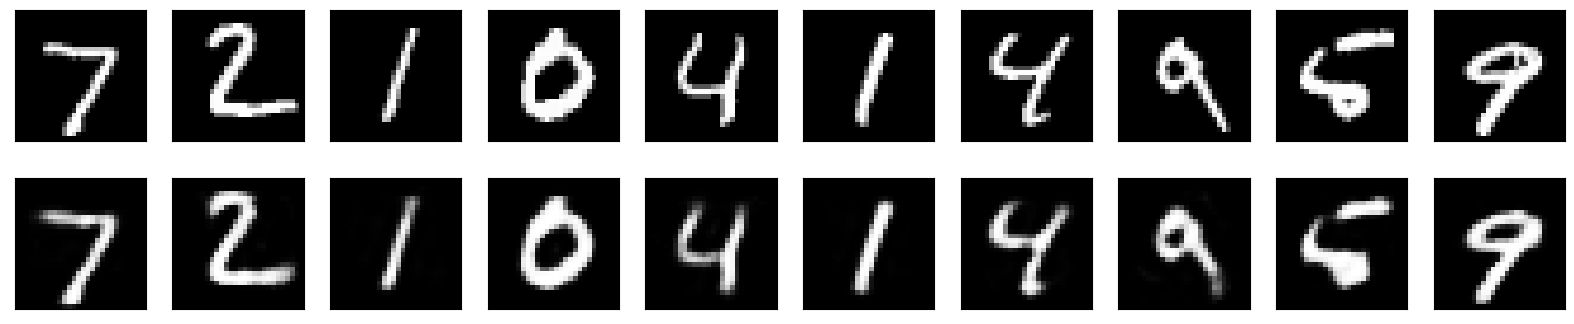

In [8]:
decoded_imgs = decoder.predict(encoded_imgs, batch_size=n)

plot_digits(imgs, decoded_imgs)


Глубокий автоэнкодер


In [9]:
def create_deep_dense_ae():
    # Размерность кодированного представления
    encoding_dim = 49

    # Энкодер
    input_img = Input(shape=(28, 28, 1))
    flat_img = Flatten()(input_img)
    x = Dense(encoding_dim*3, activation='relu')(flat_img)
    x = Dense(encoding_dim*2, activation='relu')(x)
    encoded = Dense(encoding_dim, activation='linear')(x)
    
    # Декодер
    input_encoded = Input(shape=(encoding_dim,))
    x = Dense(encoding_dim*2, activation='relu')(input_encoded)
    x = Dense(encoding_dim*3, activation='relu')(x)
    flat_decoded = Dense(28*28, activation='sigmoid')(x)
    decoded = Reshape((28, 28, 1))(flat_decoded)
    
    # Модели
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

d_encoder, d_decoder, d_autoencoder = create_deep_dense_ae()
d_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [10]:
d_autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 49)                134750    
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         135485    
                                                                 
Total params: 270,235
Trainable params: 270,235
Non-trainable params: 0
_________________________________________________________________


In [11]:
d_autoencoder.fit(x_train, x_train,
                  epochs=10,
                  batch_size=256,
                  shuffle=True,
                  validation_data=(x_test, x_test))

Epoch 1/10
235/235 [==============================] - 2s 6ms/step - loss: 0.2279 - val_loss: 0.1521
Epoch 2/10
235/235 [==============================] - 1s 5ms/step - loss: 0.1356 - val_loss: 0.1210
Epoch 3/10
235/235 [==============================] - 1s 5ms/step - loss: 0.1163 - val_loss: 0.1096
Epoch 4/10
235/235 [==============================] - 1s 5ms/step - loss: 0.1073 - val_loss: 0.1022
Epoch 5/10
235/235 [==============================] - 1s 5ms/step - loss: 0.1015 - val_loss: 0.0982
Epoch 6/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0980 - val_loss: 0.0957
Epoch 7/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0953 - val_loss: 0.0931
Epoch 8/10
235/235 [==============================] - 1s 6ms/step - loss: 0.0931 - val_loss: 0.0920
Epoch 9/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0915 - val_loss: 0.0898
Epoch 10/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0900 - val_loss: 0.0886

1/1 [==============================] - 0s 33ms/step


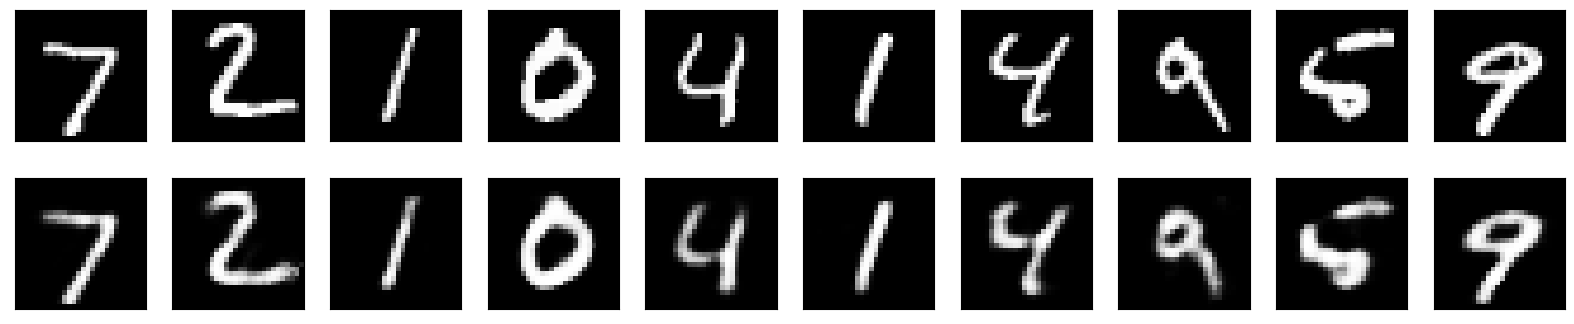

In [12]:
n = 10

imgs = x_test[:n]
encoded_imgs = d_encoder.predict(imgs, batch_size=n)
encoded_imgs[0]

decoded_imgs = d_decoder.predict(encoded_imgs, batch_size=n)

plot_digits(imgs, decoded_imgs)

Сверточный автоэнкодер


In [13]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D

def create_deep_conv_ae():
    input_img = Input(shape=(28, 28, 1))

    x = Conv2D(128, (7, 7), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (7, 7), activation='relu', padding='same')(x)

    # На этом моменте представление  (7, 7, 1) т.е. 49-размерное

    input_encoded = Input(shape=(7, 7, 1))
    x = Conv2D(32, (7, 7), activation='relu', padding='same')(input_encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (2, 2), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(x)

    # Модели
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

c_encoder, c_decoder, c_autoencoder = create_deep_conv_ae()
c_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

c_autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 7, 7, 1)           24385     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         24385     
                                                                 
Total params: 48,770
Trainable params: 48,770
Non-trainable params: 0
_________________________________________________________________


In [14]:
c_autoencoder.fit(x_train, x_train,
                epochs=3,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/3
235/235 [==============================] - 205s 869ms/step - loss: 0.1875 - val_loss: 0.1018
Epoch 2/3
235/235 [==============================] - 203s 866ms/step - loss: 0.0954 - val_loss: 0.0886
Epoch 3/3
235/235 [==============================] - 261s 1s/step - loss: 0.0875 - val_loss: 0.0857


1/1 [==============================] - 0s 38ms/step


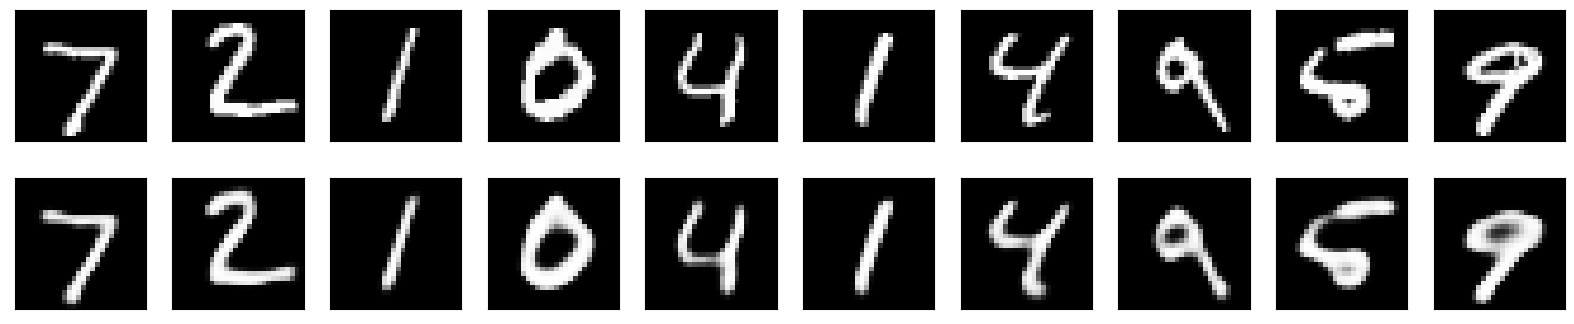

In [15]:
n = 10

imgs = x_test[:n]
encoded_imgs = c_encoder.predict(imgs, batch_size=n)
decoded_imgs = c_decoder.predict(encoded_imgs, batch_size=n)

plot_digits(imgs, decoded_imgs)

Denoising автоэнкодер


In [16]:
import keras.backend as K
from keras.layers import Lambda

batch_size = 16

def create_denoising_model(autoencoder):
    def add_noise(x):
        noise_factor = 0.5
        x = x + K.random_normal(x.get_shape(), 0.5, noise_factor)
        x = K.clip(x, 0., 1.)
        return x

    input_img  = Input(batch_shape=(batch_size, 28, 28, 1))
    noised_img = Lambda(add_noise)(input_img)

    noiser = Model(input_img, noised_img, name="noiser")
    denoiser_model = Model(input_img, autoencoder(noiser(input_img)), name="denoiser")
    return noiser, denoiser_model


noiser, denoiser_model = create_denoising_model(autoencoder)
denoiser_model.compile(optimizer='adam', loss='binary_crossentropy')

In [17]:
denoiser_model.fit(x_train, x_train,
                   epochs=10,
                   batch_size=batch_size,
                   shuffle=True,
                   validation_data=(x_test, x_test))

Epoch 1/10
3750/3750 [==============================] - 4s 885us/step - loss: 0.1428 - val_loss: 0.1320
Epoch 2/10
3750/3750 [==============================] - 3s 862us/step - loss: 0.1317 - val_loss: 0.1284
Epoch 3/10
3750/3750 [==============================] - 3s 850us/step - loss: 0.1306 - val_loss: 0.1289
Epoch 4/10
3750/3750 [==============================] - 3s 849us/step - loss: 0.1300 - val_loss: 0.1268
Epoch 5/10
3750/3750 [==============================] - 3s 867us/step - loss: 0.1296 - val_loss: 0.1276
Epoch 6/10
3750/3750 [==============================] - 3s 869us/step - loss: 0.1292 - val_loss: 0.1279
Epoch 7/10
3750/3750 [==============================] - 3s 848us/step - loss: 0.1290 - val_loss: 0.1271
Epoch 8/10
3750/3750 [==============================] - 3s 854us/step - loss: 0.1288 - val_loss: 0.1267
Epoch 9/10
3750/3750 [==============================] - 3s 858us/step - loss: 0.1287 - val_loss: 0.1279
Epoch 10/10
3750/3750 [==============================] - 3s 849u

1/1 [==============================] - 0s 8ms/step


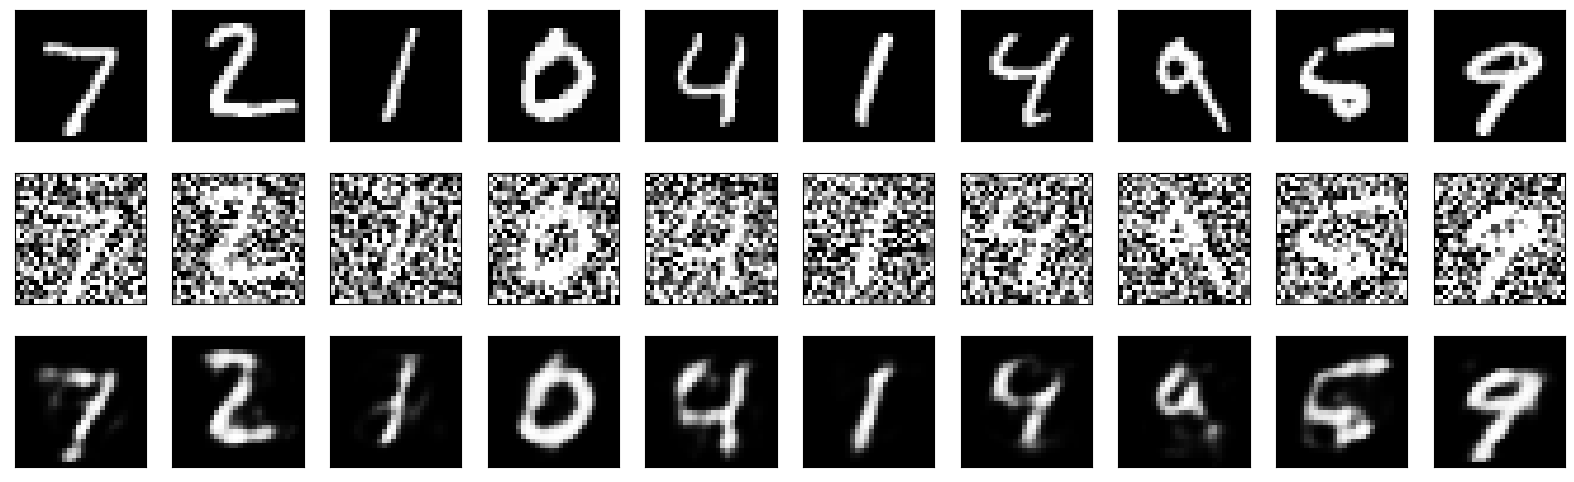

In [26]:
n = 10

imgs = x_test[:batch_size]
noised_imgs = noiser.predict(imgs, batch_size=batch_size)
encoded_imgs = encoder.predict(noised_imgs[:n],  batch_size=n)
decoded_imgs = decoder.predict(encoded_imgs[:n], batch_size=n)

plot_digits(imgs[:n], noised_imgs, decoded_imgs)

Разреженный (Sparse) автоэнкодер


In [27]:
from keras.regularizers import L1L2

def create_sparse_ae():
    encoding_dim = 16
    lambda_l1 = 0.00001
    
    # Энкодер
    input_img = Input(shape=(28, 28, 1))
    flat_img = Flatten()(input_img)
    x = Dense(encoding_dim*3, activation='relu')(flat_img)
    x = Dense(encoding_dim*2, activation='relu')(x)
    encoded = Dense(encoding_dim, activation='linear', activity_regularizer=L1L2(lambda_l1))(x)
    
    # Декодер
    input_encoded = Input(shape=(encoding_dim,))
    x = Dense(encoding_dim*2, activation='relu')(input_encoded)
    x = Dense(encoding_dim*3, activation='relu')(x)
    flat_decoded = Dense(28*28, activation='sigmoid')(x)
    decoded = Reshape((28, 28, 1))(flat_decoded)
    
    # Модели
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

s_encoder, s_decoder, s_autoencoder = create_sparse_ae()
s_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [28]:
s_autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
235/235 [==============================] - 1s 4ms/step - loss: 0.2795 - val_loss: 0.2053
Epoch 2/10
235/235 [==============================] - 1s 3ms/step - loss: 0.1838 - val_loss: 0.1658
Epoch 3/10
235/235 [==============================] - 1s 3ms/step - loss: 0.1581 - val_loss: 0.1506
Epoch 4/10
235/235 [==============================] - 1s 3ms/step - loss: 0.1487 - val_loss: 0.1446
Epoch 5/10
235/235 [==============================] - 1s 3ms/step - loss: 0.1428 - val_loss: 0.1388
Epoch 6/10
235/235 [==============================] - 1s 3ms/step - loss: 0.1376 - val_loss: 0.1342
Epoch 7/10
235/235 [==============================] - 1s 3ms/step - loss: 0.1328 - val_loss: 0.1295
Epoch 8/10
235/235 [==============================] - 1s 3ms/step - loss: 0.1290 - val_loss: 0.1263
Epoch 9/10
235/235 [==============================] - 1s 3ms/step - loss: 0.1263 - val_loss: 0.1240
Epoch 10/10
235/235 [==============================] - 1s 3ms/step - loss: 0.1244 - val_loss: 0.1222

In [29]:
n = 10

imgs = x_test[:n]
encoded_imgs = s_encoder.predict(imgs, batch_size=n)
encoded_imgs[1]

1/1 [==============================] - 0s 35ms/step


array([-13.1012745 ,   4.7892137 ,   1.8692396 ,   4.111257  ,
        -1.2662455 ,   2.2627726 ,  -2.5957503 ,   5.283046  ,
        -0.3091253 ,  -3.393575  ,  -1.2623603 ,  -4.9883513 ,
         0.17131212,  -0.4307463 , -14.298948  ,  -3.2251344 ],
      dtype=float32)

1/1 [==============================] - 0s 32ms/step


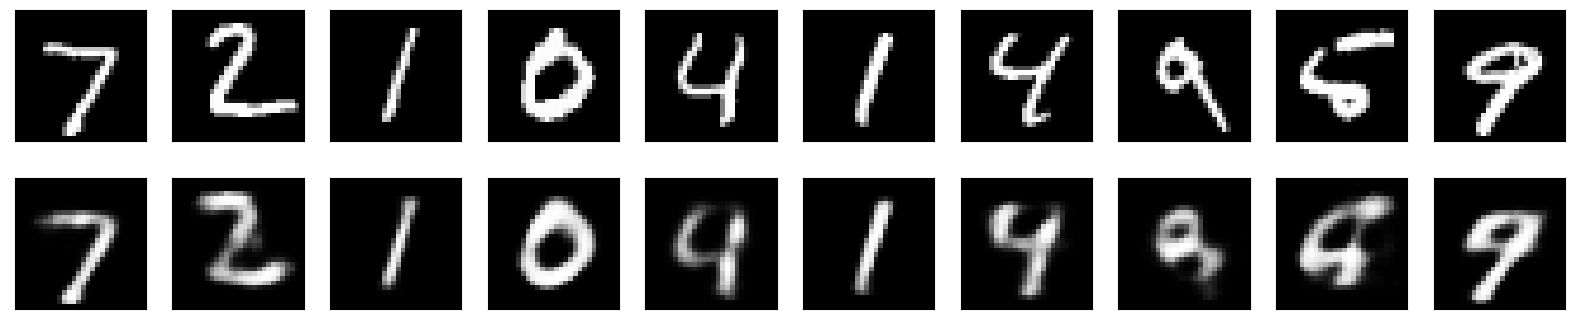

In [30]:
decoded_imgs = s_decoder.predict(encoded_imgs, batch_size=n)

plot_digits(imgs, decoded_imgs)

1/1 [==============================] - 0s 34ms/step


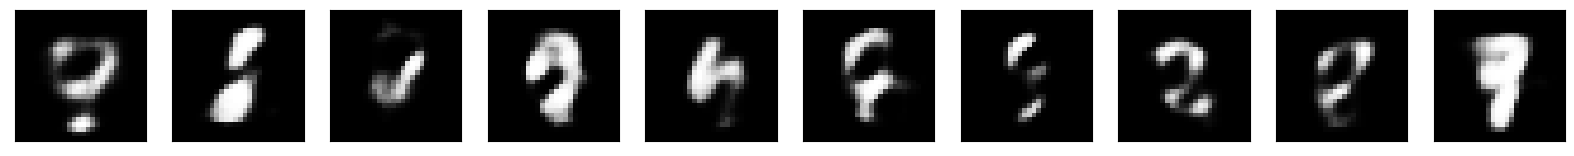

In [31]:
imgs = x_test
encoded_imgs = s_encoder.predict(imgs, batch_size=16)
codes = np.vstack([encoded_imgs.mean(axis=0)]*10)
np.fill_diagonal(codes, encoded_imgs.max(axis=0))

decoded_features = s_decoder.predict(codes, batch_size=16)
plot_digits(decoded_features)